# Discussion 4

In this discussion section we study the learning problem for one-dimensional function $f$ on the segment $[0,1]$ (**which has been studied in Discussion 1**) by using **kernel ridge regression**. It goes in parallel with problem 4 from HW4.

In [1]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import pairwise_kernels
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import fixed
from numpy import linalg as LA

In this problem you may encounter warnings that cause jupyter notebook to jump to them abruptly, which is mildly irritating. If you want to suppress those warnings, uncomment the code in the following cell and run it.

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
#kernel
def generate_kernel_widget():
    return widgets.Dropdown(
        options=['rbf', 'laplacian'],
        description='kernel: ',
        disabled=False)

#parameter of the kernel
def generate_gamma_widget():
    return widgets.FloatLogSlider(
        value=-50,
        base=np.sqrt(2),
        min=-20,
        max=40, 
        step=1,
        description='$\gamma$',
        continuous_update= False)

#number of samples
def generate_n_samples_widget():
    return widgets.IntSlider(
        value=20,
        min=1,
        max=100,
        step=1,
        description='n: ',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d')
    
# Selected index
def generate_pt_index_widget():
    return widgets.IntSlider(
        value=1,
        max=100-1, 
        step=1, 
        description='Index i: ', 
        disabled=False, 
        continuous_update=False, 
        orientation='horizontal', 
        readout=True, 
        readout_format='d')

# Scale of y
def generate_scale_widget():
    return widgets.FloatSlider(
        value=1.,
        min=1.,
        max=10,
        step=0.01, 
        description='$y$ scale', 
        continuous_update= False)

#level of regularization
def generate_reg_widget():
    return widgets.FloatLogSlider(
        value=0.,
        base=np.sqrt(2),
        min=-100,
        max=40, 
        step=1,
        description='Reg ($\lambda$):',
        continuous_update= False)

# Ground truth function
def generate_function_widget():
    return widgets.Dropdown(
        value='f-dis1',
        options=['f-dis1',
                 'sin(20x)', 
                 'piecewise linear'],
        description='True function: ',
        disabled=False)

# Noise level
def generate_sigma_widget():
    return widgets.FloatSlider(
        value=0.3,
        min=0., 
        max=0.5, 
        step=0.01,
        description='Noise ($\sigma$)',
        continuous_update= False)


## Part a ##

In this problem we study application of kernel ridge regression to the problem of learning a 1d function from samples. We are going to consider two different kernels: rbf and laplacian. The corresponding kernel functions are given by the following:
$$
K_{\text{rbf}}(x_i, x_j) = \exp(-\gamma(x_i - x_j)^2), \quad K_{\text{laplacian}}(x_i, x_j) = \exp(-\gamma|x_i-x_j|),
$$
where $\gamma$ is a parameter of the kernel. 

**Use the code in the following cell to plot $K(0, x)$ as a function of $x$ for $K$ being 'rbf' or 'laplacian' kernel. Report how changing parameter $\gamma$ influences the shape of the plot.**

In [4]:
def plot_kernel(kernel, gamma):
    X = np.expand_dims(np.linspace(-5., 5, 1000), axis=1) 
    k = pairwise_kernels(X, [[0]], metric=kernel, gamma=gamma) 
    plt.xlim(-5, 5)
    plt.ylim(-0.1, 1.1)
    plt.plot(X[:,0], k)
    
kernel_choice = generate_kernel_widget()

gamma_choice= generate_gamma_widget

interactive_plot = interactive(plot_kernel,
                                kernel=generate_kernel_widget(),
                                gamma=generate_gamma_widget())
interactive_plot

interactive(children=(Dropdown(description='kernel: ', options=('rbf', 'laplacian'), value='rbf'), FloatLogSli…

## Part b ##

The central object in kernel regression is kernel matrix.  In this part we are going to study its spectral properties. The code in the following cell samples $n$ points from the uniform distribution on $[0,1]$ and plots singular values of the kernel matrix ${\bf K} =\{K({\bf x}_i, {\bf x}_j)\}_{i,j=1}^n$. 

**Before conducting the experiement, report how you think singular values of ${\bf K}$ will depend on $\gamma$. Provide some intuition using the results of the previous part. Then run the following cell. Report how singular values of ${\bf K}$ actually depend on $n$ and $\gamma$.  Was your initial guess correct?**

In [5]:
def plot_eig_values(n_samples, kernel, gamma, seed):
    np.random.seed(seed)
    X = np.random.rand(n_samples,1)
    K = pairwise_kernels(X, X, metric=kernel, gamma=gamma) 

    eig_vals,_ = np.linalg.eig(K) 
    eig_vals = np.sort(np.abs(eig_vals))[::-1]

    plt.yscale('log')
    plt.ylim(1e-20, 1e4)
    plt.xlim([-1, n_samples+1])
    plt.plot(eig_vals, 'o-', markersize=3.0)
    plt.title('eigenvalues of K')
             
         
interactive_plot = interactive(plot_eig_values,
                               n_samples=generate_n_samples_widget(),
                               kernel=generate_kernel_widget(),
                               gamma=generate_gamma_widget(),
                               seed=fixed(1))
interactive_plot

interactive(children=(IntSlider(value=20, continuous_update=False, description='n: ', min=1), Dropdown(descrip…

## Part c ##

Now we implement the learning procedure. In part a of the problem "Kernel Ridge Regression: Theory" we derive that the prediction of ridge regression is given by 
$$\hat{f}({\bf x}) = \sum_{i=1}^n {\bf \hat\alpha}[i]K({\bf x} , {\bf x}_i).$$

**Fill in the gap in the code below to compute the weight vector ${\bf \hat\alpha}$**

In [6]:
def compute_predictor(X, y,  lambda_reg, kernel, gamma):
        """
    Input:
        X: data matrix
        y: outputs
        lambda_reg: regularization term in kernel ridge regression
        kernel: which kernel to use ['poly', 'rbf', 'laplacian']
        gamma: kernel parameter

    Output:
        predictor: predict using the kernel ridge model
        dual_coef: representation of weight vector(s) in kernel space, i.e. alpha
    """

        K = pairwise_kernels(X, X, metric=kernel, gamma=gamma) + lambda_reg * np.eye(len(y))
        ### start c ###
        
        ### end c ###
        return lambda x: pairwise_kernels(x, X, metric=kernel, gamma=gamma)  @ alpha, alpha

## Part d ##

We know that our prediction $\hat{f}(x)$ is linear in ${\bf y}$ - our measured values. In this part we will see how each individual measurement affects the prediction. 

The following code allows you to choose index $i$ and then plots the prediction of ridge regression for the case when $y_i = y_{\text{scale}}$, and $y_{j} = 0$ for $j \neq i$. In other words, we observe the response that impulse signal in the $i$-th point adds to the total prediction $\hat{f}({\bf x}).$ The second plot shows coefficients of the vector $\hat{\bf \alpha}$.

1. **Set lambda to the minimal value. For which kernel does the impulse response behave more robustly when you change n and gamma? How does this align with the results of part b?**
2. **Report what happens to the vector ${\bf \hat\alpha}$ as you increase gamma. Explain why this happens using part a and the formula for ${\bf \hat\alpha}$**
3. **Set lambda to be of order $10^{-7}$. For which value of gamma is the impulse response closest to the step function? How do you think the performance of ridge regression in this regime would compare to 1 nearest neighbour regression?**


In [7]:
def plot_kernel_impulse(kernel, n_samples, gamma, lambda_reg, pt_index, pt_scale):
    n_features  = 1
    rng = np.random.RandomState(1)
    

    X = np.sort(rng.rand(n_samples, n_features), axis=0)
    
    # Impulse (set the [pt_index]-th in y as 1)
    y = np.eye(n_samples)[pt_index, :] * pt_scale
    
    def stair_function(X, value_x):
        band_width = 0.02
        num = X.shape[0]
        Y = np.zeros(num)
        idx = np.where(np.abs(X - value_x) < band_width)[0]
        Y[idx] = 1.0
        return Y

    # Kernel Ridge Regression Solver
    predictor, alpha_ = compute_predictor(X, y, lambda_reg=lambda_reg, kernel=kernel, gamma=gamma)
    
    clip_bound = 2.5
    # Sample test data points
    X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
    X_test = np.sort(X_test, axis=0)

    # Visualization
    plt.figure(figsize=(10,5))
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.plot(X_test, stair_function(X_test, X[pt_index, :]), '--', c='coral', label='stair')
    plt.scatter(X[:,0], y, c='blue', s=5, label='Data points')
    plt.scatter(X[pt_index,0], y[pt_index], c='darkorange', label='One data point')
    plt.plot(X_test, predictor(X_test), '-', color='forestgreen',  label='xi_{i}(x_test)')
    plt.title('Impulse function')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.xlim(0, 1)
    markerlines, stemlines,  baseline = plt.stem(X[:,0], alpha_, 'b', 'o',  use_line_collection=True)
    plt.setp(stemlines, 'color', plt.getp(markerlines,'color'))
    plt.title('Weights in points')
    plt.show()
    

interactive_plot_impulse = interactive(plot_kernel_impulse,
                                       n_samples=generate_n_samples_widget(), 
                                       kernel=generate_kernel_widget(),
                                       gamma=generate_gamma_widget(),
                                       lambda_reg=generate_reg_widget(),
                                       pt_index=generate_pt_index_widget(),
                                       pt_scale=generate_scale_widget())
interactive_plot_impulse

interactive(children=(Dropdown(description='kernel: ', options=('rbf', 'laplacian'), value='rbf'), IntSlider(v…

### Part e ###

In this part we study the approximation abilities of our kernels, i.e. we will generate data without noise and see how well the kernel regression can learn. Run the code in the next cell to see three functions that we will try to learn.

Text(0.5, 1.0, 'piecewise linear function')

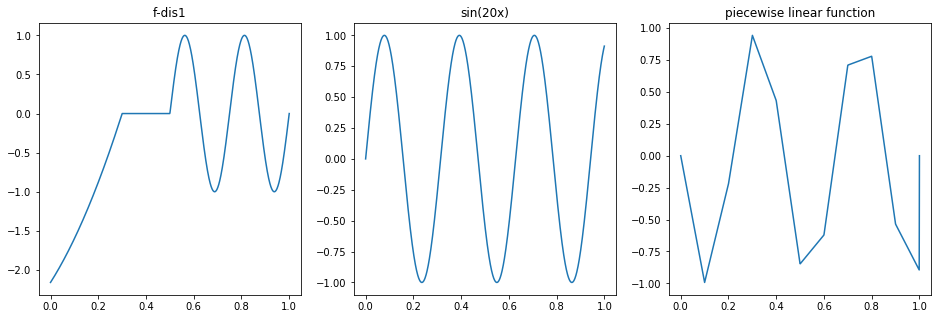

In [8]:
def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    elif f_type == 'f-dis1':
        X = X[:, 0]
        y = np.zeros(len(X))
        y[X < 0.3] = 8 * (X[X < 0.3] + 0.3)**2 - 2.88
        y[X > 0.5] = np.sin(2 * np.pi * (X[X> 0.5]-0.5) * 4)
        return y
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX)) 
X = np.expand_dims(np.linspace(0, 1, 1000), axis=1)

plt.figure(figsize=(16,5))
plt.subplot(131)
plt.plot(X[:, 0], f_true(X, 'f-dis1'))
plt.title('f-dis1')
plt.subplot(132)
plt.plot(X[:, 0], f_true(X, 'sin(20x)'))
plt.title('sin(20x)')
plt.subplot(133)
plt.plot(X[:, 0], f_true(X, 'piecewise linear'))
plt.title('piecewise linear function')


In the following cell we will see how well kernel regression can learn the true function. **Before conducting the expreiements report which kernel in your oppinion will be better for each of the funtions above. Use the previous part to provide some intuition supporting your guess. After that, run the following cell and report the following:**
1. **Set lambda to the minimum value and try to approximate both functions using both kernels by choosing gamma. For each of the functions report which kernel achieves better approximation.**
2. **Now do the same, but set lambda to be of order $10^{-8}$.**
3. **Set gamma to be of order $10^2$ and try to approximate both functions using both kernels by choosing lambda. Answer the same question as before.**
4. **Report what happens when either $\gamma$ or $\lambda$ is chosen to be very large.**
5. **Was your initial guess correct?**

In [9]:
def plot_kernel_ridge_regression(kernel, n_samples,  gamma, sigma, f_type, lambda_reg):
    n_features = 1
    rng = np.random.RandomState(1)

    X = np.sort(rng.rand(n_samples, n_features), axis=0)
    
    # Generate y
    y = f_true(X, f_type) + rng.randn(n_samples) * sigma

    # Kernel Ridge Regression Solver
    predictor, alpha_ = compute_predictor(X, y, lambda_reg, kernel=kernel, gamma=gamma)
    
    clip_bound = 2.5
    # Sample test data points
    X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
    X_test = np.sort(X_test, axis=0)

    # Visualization
    plt.figure(figsize=(10,7))
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.plot(X_test, predictor(X_test), '-', color='forestgreen',  label='prediction')
    plt.scatter(X[:,0], y, c='darkorange', s=40.0, label='training data points')
    plt.plot(X_test, f_true(X_test, f_type), '--', color='royalblue', linewidth=2.0, label='Ground truth')
    plt.legend()




interactive_plot = interactive(plot_kernel_ridge_regression,
                               n_samples=fixed(50),
                               kernel=generate_kernel_widget(),
                               gamma=generate_gamma_widget(),
                               sigma=fixed(0),
                               f_type = generate_function_widget(),
                               lambda_reg=generate_reg_widget())
interactive_plot

interactive(children=(Dropdown(description='kernel: ', options=('rbf', 'laplacian'), value='rbf'), FloatLogSli…

### Part f ###

In this part (and the following parts) we investigate how our predictions are affected by noise. Here we only consider one of two functions from before (namely $f(x) = f_{\text{dis-1}}(x)$), but we add noise to our data. $f_{\text{dis-1}}(x)$ is similar to the the function in **Discussion 1**,

$$
f_{\text{dis-1}}(x) = \begin{cases}
8(x + 0.3)^2 - 2.88 & x \in [0, 0.3]\\
0& x\in[0.3, 0.5]\\
4\sin(2\pi (x - 0.5))& x \in [0.5, 1].
\end{cases}
$$

The data points $\{x_i\}_{i=1}^n$ from $[0, 1]$ and learn $f$ from values $\{f(x_i) + \epsilon_i\}$, where $\{\epsilon_i\}_{i=1}^n$ is some additive noise.

1. **Set lambda to minimum value and sigma to zero. For each kernel find the range of gamma for which the prediction looks close to $f(x)$. Then set noise to the maximum value and report for which values of gamma the predictions were more persistent to that noise. How do your observations align with the results of part b?**
2. **Set noise to maximum and try to find the best prediction for each kernel (you can choose both gamma and lambda). Report for which kernel you could achieve the better result. For which kernel is the prediction more sensitive to the choice of parameters?**

In [10]:
def plot_kernel_ridge_regression(kernel, n_samples,  gamma, sigma, f_type, lambda_reg):
    n_features = 1
    rng = np.random.RandomState(1)



    X = np.sort(rng.rand(n_samples, n_features), axis=0)
    
    # Generate y
    y = f_true(X, f_type) + rng.randn(n_samples) * sigma

    # Kernel Ridge Regression Solver
    predictor, alpha_ = compute_predictor(X, y, lambda_reg, kernel=kernel, gamma=gamma)
    
    clip_bound = 2.5
    # Sample test data points
    X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
    X_test = np.sort(X_test, axis=0)

    # Visualization
    plt.figure(figsize=(10,7))
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.plot(X_test, predictor(X_test), '-', color='forestgreen',  label='prediction')
    plt.scatter(X[:,0], y, c='darkorange', s=40.0, label='training data points')
    plt.plot(X_test, f_true(X_test, f_type), '--', color='royalblue', linewidth=2.0, label='Ground truth')
    plt.legend()




interactive_plot = interactive(plot_kernel_ridge_regression,
                               n_samples=fixed(50),
                               kernel=generate_kernel_widget(),
                               gamma=generate_gamma_widget(),
                               sigma=generate_sigma_widget(),
                               f_type = fixed('f-dis1'),
                               lambda_reg=generate_reg_widget())
interactive_plot

interactive(children=(Dropdown(description='kernel: ', options=('rbf', 'laplacian'), value='rbf'), FloatLogSli…

### Part g ###

Now we observe how our parameters influence the generalization error.

We first study the regularization parameter ($\lambda$).

1. **Report what happens to the best regularization parameter ($\lambda^{\star}$) when you increase the noise level $\sigma$ (from $\sigma=0.0$ to $\sigma=0.5$).**
2. **Was your initial guess correct?**

In [11]:
def calculate_loss(y_pred, y):
    """Calculate the loss of the model on data X."""
    n = y_pred.shape[0]
    delta_y = y_pred - y
    return np.sum(delta_y**2)/n

def plot_test_error_lambda(sigma):
    # Generate X_train/y_train
    train_n_samples, num_features = 100, 1
    X_train = np.random.rand(train_n_samples, num_features)
    y_train = f_true(X_train, 'f-dis1') + np.random.randn(train_n_samples) * sigma

    # Generate X_test/y_test
    test_n_samples = 10000
    X_test = np.random.rand(test_n_samples, num_features)
    y_test = f_true(X_test, 'f-dis1')
    # Kernel parameter - gamma
    gamma = 500.0

    # Calculate test loss/norm of dual solution/condition number of (K+\lambda*I)
    loss_test_reg = []
    solution_norm_reg = []
    # Setup a range of regularization parameters from 1e-5 to 1e5
    lambda_reg_set = np.logspace(-17, 5, 100, endpoint=True) 
    for lambda_reg in lambda_reg_set:
        # solve kernel ridge regression
        predictor, alpha_= compute_predictor(X_train, y_train, lambda_reg=lambda_reg, kernel='rbf', gamma=gamma)
        # get prediction on X_test
        y_pred = predictor(X_test)
        loss_test_reg.append(calculate_loss(y_pred, y_test))
        solution_norm_reg.append(LA.norm(alpha_))
    # Find best regularization parameter
    idx_min = np.argmin(np.array(loss_test_reg))
    # Calculate the test loss of all zero predictor
    loss_all_zero = calculate_loss(np.zeros_like(y_test), y_test)

    # Visualization
    plt.figure(figsize=(7,5))
    plt.plot(lambda_reg_set, loss_test_reg, "d:", color='royalblue', markersize=5.0, label="Test Loss")
    plt.axvline(x=lambda_reg_set[idx_min], color='darkorange', linestyle='-', label='Best Regularization')
    plt.axhline(y=loss_all_zero, color='red', linestyle='--', linewidth=1.5, label="All-zero-solution")
    plt.legend(loc="best")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Lambda (Regularization)')
    plt.ylabel('Test Loss')
    plt.title('Test Loss of Different Regularization (Lambda)')
    plt.tight_layout()
    plt.show()
    
interactive_plot = interactive(plot_test_error_lambda, sigma=generate_sigma_widget())
interactive_plot

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='Noise ($\\sigma$)', max=0.5…

### Part h ###

Next we study the kernel parameter ($\gamma$).

1. **Report what happens to the best kernel parameter ($\gamma^{\star}$) when you increase the noise level $\sigma$ (from $\sigma=0.0$ to $\sigma=0.5$).**
2. **Is there a difference in terms of the shape of the curve when you change the noise level?** **Try to explain what causes the difference.**
3. **Was your initial guess correct?**

In [12]:
def plot_test_error_gamma(sigma):
    # Define ground truth function

    # Generate X_train/y_train
    train_n_samples, num_features = 100, 1
    X_train = np.random.rand(train_n_samples, num_features)
    y_train = f_true(X_train, 'f-dis1') + np.random.randn(train_n_samples) * sigma

    # Generate X_test/y_test
    test_n_samples = 10000
    X_test = np.random.rand(test_n_samples, num_features)
    y_test = f_true(X_test, 'f-dis1')
    
    # Calculate loss of zero prediction
    loss_all_zero = calculate_loss(np.zeros_like(y_test), y_test)
    # Setup a range of gamma parameters from 1e-1 to 1e8
    gamma_set = np.logspace(0.1, 9, 50, endpoint=True) * 0.1

    # Set lambda as 1e-8
    lambda_reg = 1e-8

    loss_test_gamma = []
    condition_number_gamma = []

    for gamma in gamma_set:
        # solve kernel ridge regression
        predictor, _ = compute_predictor(X_train, y_train, lambda_reg=lambda_reg, kernel='rbf', gamma=gamma)
        # get prediction on X_test
        y_pred = predictor(X_test)
        loss_test_gamma.append(calculate_loss(y_pred, y_test))
    # Find best gamma parameter
    idx_min = np.argmin(np.array(loss_test_gamma))

    # Visualization
    plt.figure(figsize=(8,6))
    plt.plot(gamma_set, loss_test_gamma, "d:", color='royalblue', markersize=5.0, label="Test Loss")
    plt.axvline(x=gamma_set[idx_min], color='darkorange', linestyle='-', label='Best Regularization')
    plt.axhline(y=loss_all_zero, color='red', linestyle='--', linewidth=1.5, label="All-zero-solution")
    # plt.axhline(y=0.0, color='green', linestyle=':', linewidth=0.8)
    plt.legend(loc="best")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('gamma')
    plt.ylabel('Test Loss')
    plt.title('Test Loss of Different Kernel Parameter (gamma)')
    # plt.ylim((-0.1, 40.0))
    plt.tight_layout()
    plt.show()
interactive_plot = interactive(plot_test_error_gamma,
                               sigma=generate_sigma_widget())
interactive_plot

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='Noise ($\\sigma$)', max=0.5…

### Part i ###

### $k$-Fold Cross-Validation

Based on the above two parts, we find that the test loss can be sensitive to hyperparameters. In this part, we fix the kernel parameter ($\gamma=200$) and try to apply $k$-fold cross validation to select the regularization parameter ($\lambda$). To start with, we use $k=5$. The function that we learn is $f_{\text{dis-1}}$

1. **Report the the performance of the picked regularization parameter (by $k$-Fold Cross-Validation) on the test data points.**
2. **Study the effect of $k$, change $k=5$ to $k=2, 4, 8, 10, 20$, does the picked hyperparameter sensitive to $k$?**
2. **Was your initial guess correct?**

In [13]:
rng = np.random.RandomState(1)



# Set up noise level
sigma = 0.2

# Generate X_train/y_train
train_n_samples, num_features = 100, 1
X_train = rng.rand(train_n_samples, num_features)
y_train = f_true(X_train, 'f-dis1') + rng.randn(train_n_samples) * sigma

# Generate X_val/y_val (50 data points)
val_n_samples = 50
X_val = rng.rand(val_n_samples, num_features)
y_val = f_true(X_val, 'f-dis1') + rng.randn(val_n_samples) * sigma

# Generate X_test/y_test
test_n_samples = 10000
X_test = rng.rand(test_n_samples, num_features)
y_test = f_true(X_test, 'f-dis1')

# Set gamma = 200
gamma = 200

loss_all_zero = calculate_loss(np.zeros_like(y_test), y_test)

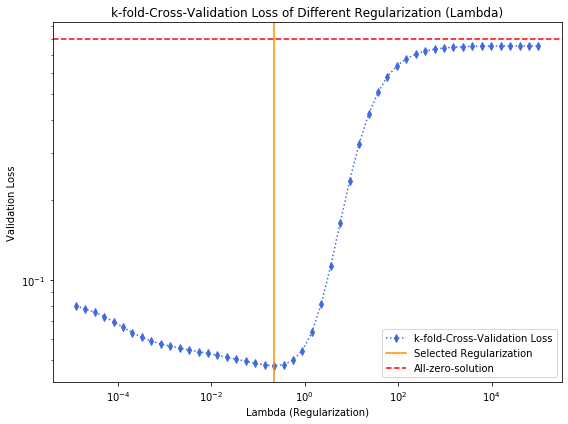

In [14]:
from sklearn.model_selection import KFold

# Setup a range of regularization parameters from 1e-5 to 1e5
reg_lambda_set = np.logspace(0.1, 10, 50, endpoint=True) * 0.00001

# Merge X_train and X_val
X_merge = np.concatenate((X_train, X_val), axis=0)
y_merge = np.concatenate((y_train, y_val), axis=0)

# Setup K-Fold
## TODO: Setup you K here
K = 5
kf = KFold(n_splits=K)
kf.get_n_splits(X_merge)
loss_k_fold = []

for reg_lambda in reg_lambda_set:
    loss_avg = 0.0
    for train_index, test_index in kf.split(X_merge):
        # The current training points are 'X_merge[train_index]'
        # The current validation points are 'X_merge[test_index]'

        # 1). Estimate the mean with regularization alpha
        # 2). Compute the k-fold loss (L_{k-fold}(\alpha)) 
        # 3). Add the the k-fold loss (L_{k-fold}(\alpha)) to the list 'loss_k_fold'
        predictor, _ = compute_predictor(X_merge[train_index], y_merge[train_index], lambda_reg=reg_lambda, kernel='rbf', gamma=gamma)
        # get prediction on X_merge[test_index]
        y_pred = predictor(X_merge[test_index])
        loss_avg += calculate_loss(y_pred, y_merge[test_index])/K
    loss_k_fold.append(loss_avg)

# Select the best hyperparameter via k-fold
idx_k_fold_min = np.argmin(np.array(loss_k_fold))

# Visualization
plt.figure(figsize=(8,6))
plt.plot(reg_lambda_set, loss_k_fold, "d:", color='royalblue', markersize=5.0, label="k-fold-Cross-Validation Loss")
plt.axvline(x=reg_lambda_set[idx_k_fold_min], color='darkorange', linestyle='-', label='Selected Regularization')
plt.axhline(y=loss_all_zero, color='red', linestyle='--', linewidth=1.5, label="All-zero-solution")
plt.legend(loc="best")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda (Regularization)')
plt.ylabel('Validation Loss')
plt.title('k-fold-Cross-Validation Loss of Different Regularization (Lambda)')
plt.tight_layout()
plt.show()
plt.close()

Then we evaluate the models on the test data points. Note that the there is no noise $\epsilon$ in the test data points.

In [15]:
loss_test = []

for reg_lambda in reg_lambda_set:
    predictor, _ = compute_predictor(X_merge, y_merge, lambda_reg=reg_lambda, kernel='rbf', gamma=gamma)
    # get prediction on X_test
    y_pred = predictor(X_test)
    loss_test.append(calculate_loss(y_pred, y_test))

# Select the best hyperparameter for test loss
idx_test_min = np.argmin(np.array(loss_test))

Then we visualize the test loss together with the $k$-fold cross-validation loss in the same plot.

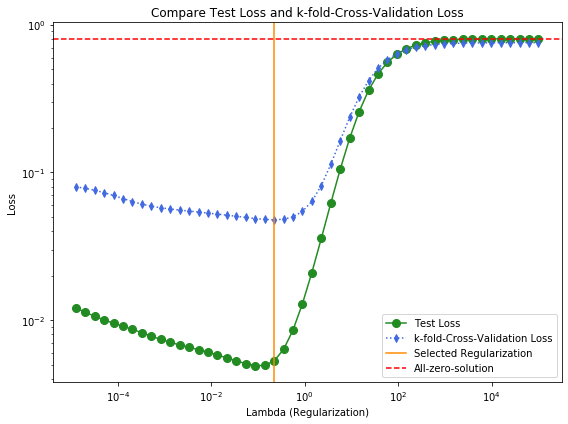

In [16]:
rng = np.random.RandomState(1)

# Visualization
plt.figure(figsize=(8,6))
plt.plot(reg_lambda_set, loss_test, "o-", color='forestgreen', markersize=8.0, label="Test Loss")
plt.plot(reg_lambda_set, loss_k_fold, "d:", color='royalblue', markersize=5.0, label="k-fold-Cross-Validation Loss")
plt.axvline(x=reg_lambda_set[idx_k_fold_min], color='darkorange', linestyle='-', label='Selected Regularization')
plt.axhline(y=loss_all_zero, color='red', linestyle='--', linewidth=1.5, label="All-zero-solution")
plt.legend(loc="best")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda (Regularization)')
plt.ylabel('Loss')
plt.title('Compare Test Loss and k-fold-Cross-Validation Loss')
plt.tight_layout()
plt.show()
plt.close()